# Initialization

In [36]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import concurrent.futures

In [5]:
def calc_shannon(x):
    x[x < 0] = 0
    x_sum = np.sum(x, axis=-1, keepdims=True)
    x = x / (x_sum + 1e-10)  # relative abundance, avoid div by zero
    return -np.sum(x * np.log(x + 1e-10), axis=-1)

def calc_alpha(N):
    return np.sum(N > 1e-6)

# Demo

Text(0.5, 1.0, 'Daily dilution')

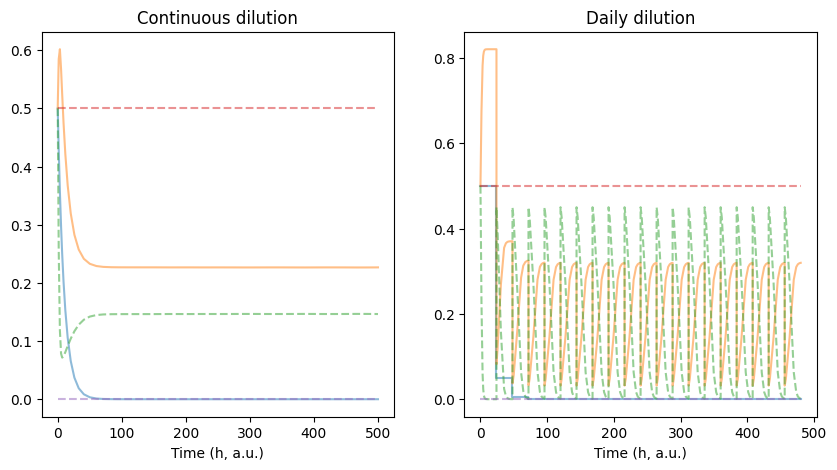

In [38]:
from sim_1219_01 import generate_crmodel

crm = generate_crmodel(2, 3, [0])[0]
N0 = np.array([0.5, 0.5])
R0 = np.array([0.5, 0.5, 0])

dil = 0.1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# continuous dilution simulation
sol_c = crm.sim([0, 500], N0, R0, dil=dil, Rsupp=R0, nRsupp=1)
plt.sca(axes[0])
plt.plot(sol_c.t, sol_c.y[:crm.nS, :].T, alpha=0.5)
plt.plot(sol_c.t, sol_c.y[crm.nS:, :].T, '--', alpha=0.5)
plt.xlabel('Time (h, a.u.)')
plt.title('Continuous dilution')
# daily dilution simulation
sol_d = crm.sim_daily_dil(20, dil, N0, R0, Rsupp=R0, T=24, nRsupp=1)
plt.sca(axes[1])
plt.plot(sol_d.t, sol_d.y[:crm.nS, :].T, alpha=0.5)
plt.plot(sol_d.t, sol_d.y[crm.nS:, :].T, '--', alpha=0.5)
plt.xlabel('Time (h, a.u.)')
plt.title('Daily dilution')

# Run simulations (in workstation terminal)

```
mkdir simres_1219_01
nohup nice -n 20 python3 -u sim_1219_01.py > simres_1219_01/log_nohup 2>&1 &

mkdir simres_1219_02
nohup nice -n 20 python3 -u sim_1219_02.py > simres_1219_02/log_nohup 2>&1 &

mkdir simres_1219_02
nohup nice -n 20 python3 -u sim_1219_03.py > simres_1219_03/log_nohup 2>&1 &

mkdir simres_1219_03
nohup nice -n 20 python3 -u sim_1219_04.py > simres_1219_04/log_nohup 2>&1 &

mkdir simres_1219_05
nohup nice -n 20 python3 -u sim_1219_05.py > simres_1219_05/log_nohup 2>&1 &
```

# Simulation result loading, processing, and plotting

## 1219_01: cross feeding * correlation with generalism, full factor

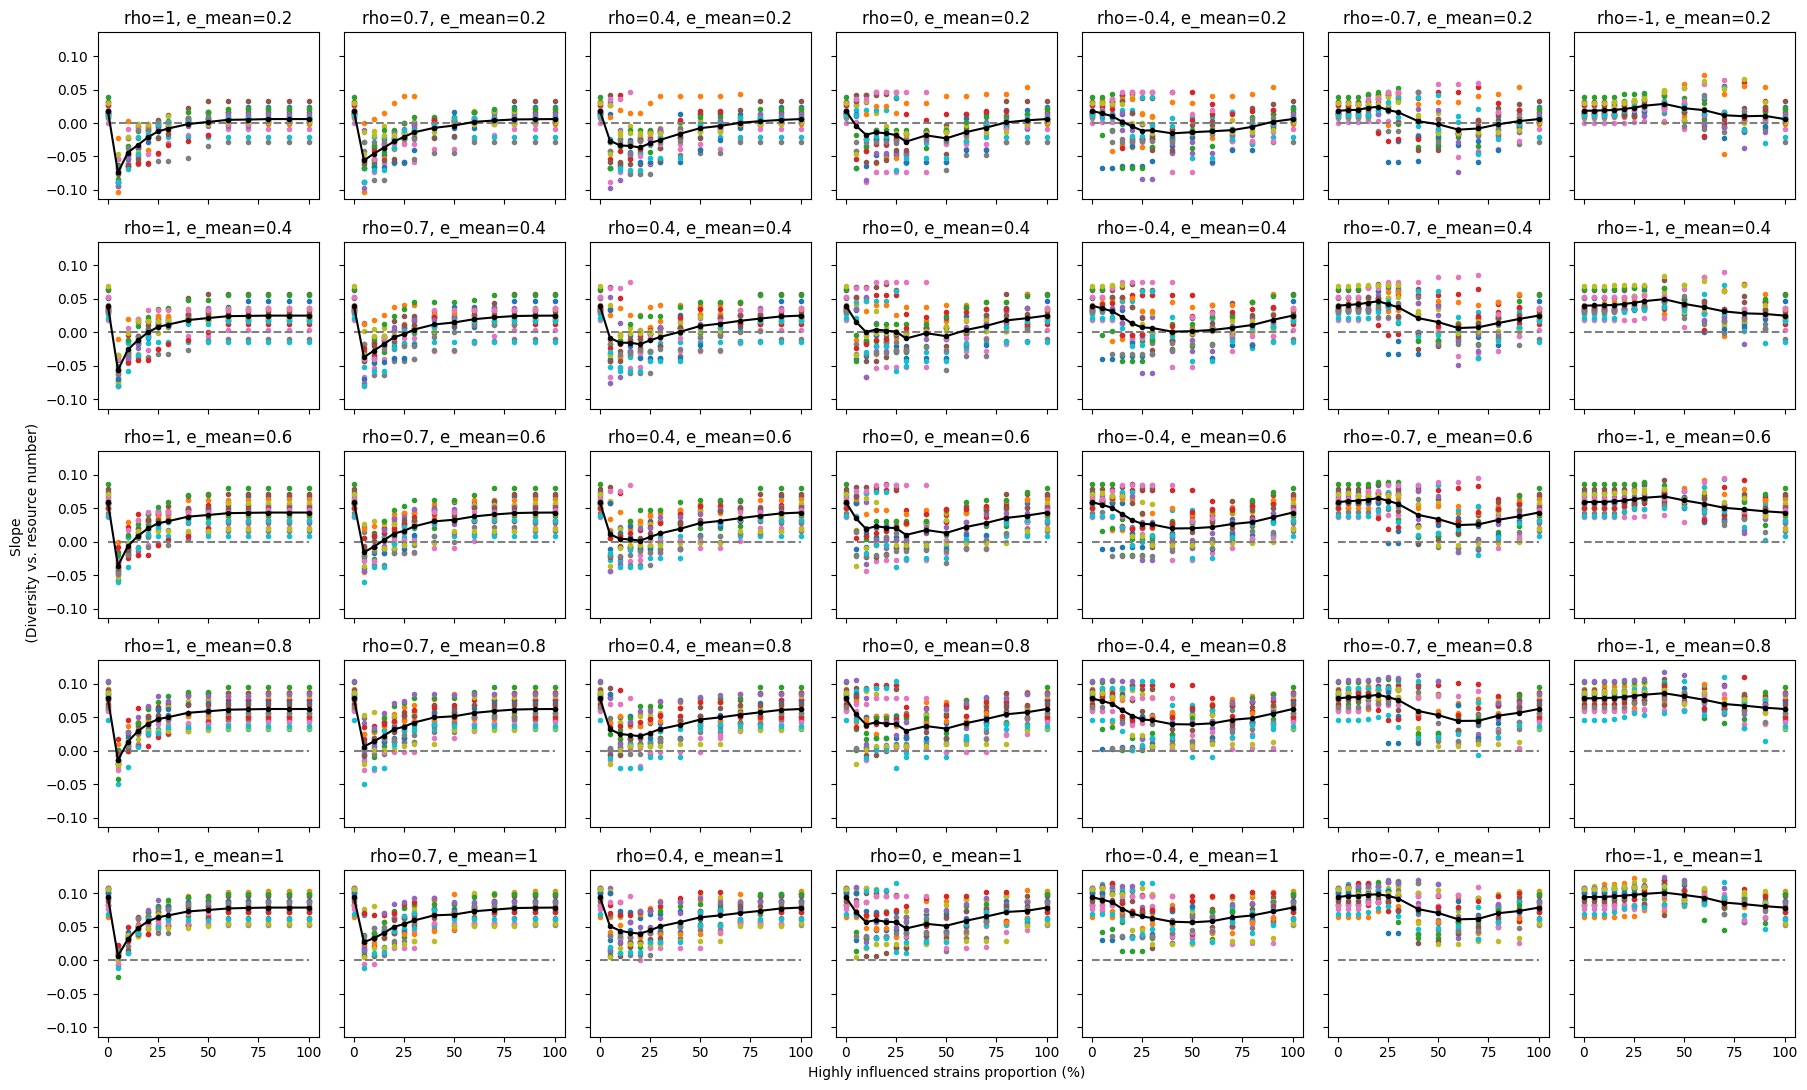

In [35]:
respath = "./simres_1219_01"

# Model parameters
nS, nR = 20, 30
nRsupp_list = np.repeat([1, 2, 4, 8, 16], 3)
# Use only 1 and 16 for slope calc, to be compatible with Or's calculations
USE_FOR_SLOPE_CALC = np.concatenate([np.where(nRsupp_list == 1)[0], np.where(nRsupp_list == 16)[0]])
# USE_FOR_SLOPE_CALC = np.arange(len(nRsupp_list))  # Use all for slope calc

# Fractions of HACC to test
f_list = np.concatenate([np.arange(0, 0.3, 0.05), np.arange(0.3, 1.01, 0.1)])
comm_list = np.arange(20)
nComm = len(comm_list) # Number of communities per parameter set

e_mean_list = [0.2, 0.4, 0.6, 0.8, 1]
rho_gamma_list = [1, 0.7, 0.4, 0, -0.4, -0.7, -1]
gamma_macc, gamma_hacc = 0, 1
k_gamma = np.inf  # step function

fig, axes = plt.subplots(len(e_mean_list), len(rho_gamma_list), figsize=(len(rho_gamma_list)*2.6, len(e_mean_list)*2.2),
                     sharex=True, sharey=True)
axes = np.array(axes).reshape((len(e_mean_list), len(rho_gamma_list)))  # ensure 2D array even if one row only

for iemean, e_mean in enumerate(e_mean_list):
    for irho, rho_gamma in enumerate(rho_gamma_list):        
        plt.sca(axes[iemean, irho])
        plt.title(f"rho={rho_gamma}, e_mean={e_mean}")
    
        slope_arr = np.zeros((len(comm_list), len(f_list)))  # ncomm, nfrac
        slope_arr.fill(np.nan)
        
        first_comm = True
        for icomm, comm in enumerate(comm_list):
            try:
                with open(f'{respath}/rhogamma={rho_gamma:.2f}_emean={e_mean:.1f}/Nfin_com{icomm:03d}.pkl', 'rb') as f:
                    data = pickle.load(f)
            except FileNotFoundError:
                print(f"File for community {comm} not found. Skipping.")
                continue
    
            if isinstance(data['final_abundance_allfracs'][0], np.ndarray):
                nfin = np.array(data['final_abundance_allfracs'])  # (nfrac, ndiv, nspecies + nresources)
            else:
                nfin = np.array([data['final_abundance_allfracs'][ifrac][0] for ifrac in range(len(data['f_list']))])
            
            # ---- Calculate Shannon diversity and slopes ----
            shannon_div_all = np.zeros(nfin.shape[0:2])
            for ifrac in range(nfin.shape[0]):
                for idiv in range(nfin.shape[1]):
                    shannon_div_all[ifrac, idiv] = calc_shannon(nfin[ifrac, idiv, :data['crm_base'].nS])
    
            for ifrac in range(nfin.shape[0]):
                k, b = np.polyfit(nRsupp_list[USE_FOR_SLOPE_CALC], shannon_div_all[ifrac, USE_FOR_SLOPE_CALC], 1)
                slope_arr[icomm, ifrac] = k
                            
            # ---- Fill final abundances into a DataFrame with metadata ----    
            # 1. Setup constants and replicate logic
            nR_len = len(nRsupp_list)
            replicates = np.tile([1, 2, 3], nR_len // 3)
            
            dfs = []
            
            # 2. Loop through the fraction dimension only
            for ifrac, f in enumerate(f_list):
                # Extract the (nR_len, nS) block for this f
                abundance_block = nfin[ifrac, :, :data['crm_base'].nS]
                                
                # Create the block of strain data
                temp_df = pd.DataFrame(abundance_block, columns=[f'strain{i+1}' for i in range(nS)])
                
                # Add metadata (broadcasting handles the single values)
                temp_df['community_id'] = icomm
                temp_df['number_of_resources(nRsupp)'] = nRsupp_list
                temp_df['resource_mix_id'] = range(nR_len)
                temp_df['fraction_of_HACC(f)'] = f
                temp_df['number_of_species(nS)'] = nS
                temp_df['resource_use_efficiency(e_mean)'] = e_mean
                temp_df['HACC_correlation_with_generalist(rho_gamma)'] = rho_gamma
                temp_df['MACC_HACC_transition_steepness(k_gamma)'] = np.minimum(100, k_gamma)  # >=100 was treated as step function
                temp_df['gamma_MACC'] = gamma_macc
                temp_df['gamma_HACC'] = gamma_hacc
                                
                # Generate gammas for this specific f
                n_hacc = int(nS * f)
                n_macc = nS - n_hacc
                gammas = np.concatenate([np.ones(n_macc) * gamma_macc, 
                                         np.ones(n_hacc) * gamma_hacc])
                # Add gamma values (broadcasting the 1D 'gammas' array across all rows in temp_df)
                gamma_cols = [f'gamma_strain{i+1}' for i in range(nS)]
                temp_df[gamma_cols] = gammas
                
                # Add niche width
                niche_width = np.sum((data['crm_base'].v0 > 0).astype(int), axis=1) / data['crm_base'].nR
                niche_cols = [f'niche_width_strain{i+1}' for i in range(nS)]
                temp_df[niche_cols] = niche_width
                
                dfs.append(temp_df)
            
            # 3. Combine everything into one master DataFrame
            df_data_curr = pd.concat(dfs, ignore_index=True)
            if first_comm:
                df_data = df_data_curr
                first_comm = False
            else:
                df_data = pd.concat([df_data, df_data_curr], ignore_index=True)
                
        # ---- Saving the DataFrame ----
        df_data.to_csv(f'{respath}/final_abundances_rhogamma_{rho_gamma:.2f}_emean_{e_mean:.1f}.csv', index=False)
        
        # ---- Plotting ----
        # individual communities
        plt.plot(data['f_list'] * 100, slope_arr.T, '.')
        plt.plot(data['f_list'] * 100, np.zeros(len(data['f_list'])), '--', color='gray')
            
        # median + error bars across communities
        med = np.nanmedian(slope_arr, axis=0)
        mean = np.nanmean(slope_arr, axis=0)
        lo = np.nanpercentile(slope_arr, 25, axis=0)
        hi = np.nanpercentile(slope_arr, 75, axis=0)
    
        # asymmetric errorbars: (median-lo, hi-median)
        yerr = np.vstack([med - lo, hi - med])
    
        # plt.errorbar(f_list * 100, med, yerr=yerr, fmt='-ok', capsize=3)
        # plt.errorbar(f_list * 100, med, fmt='-ok', capsize=3)
        plt.errorbar(data['f_list'] * 100, mean, fmt='.-k', capsize=3)
        if iemean == len(e_mean_list) - 1 and irho == len(rho_gamma_list) // 2:
            plt.xlabel("Highly influenced strains proportion (%)")
        if iemean == len(e_mean_list) // 2 and irho == 0:
            plt.ylabel("Slope \n (Diversity vs. resource number)")
    
plt.tight_layout()
plt.show()
fig.savefig(f"{respath}/crmodel_sup01_rhogamma_e_mean.svg")

### A more detailed inspection of the main panel (rho_gamma=0.4, e_mean=0.4)

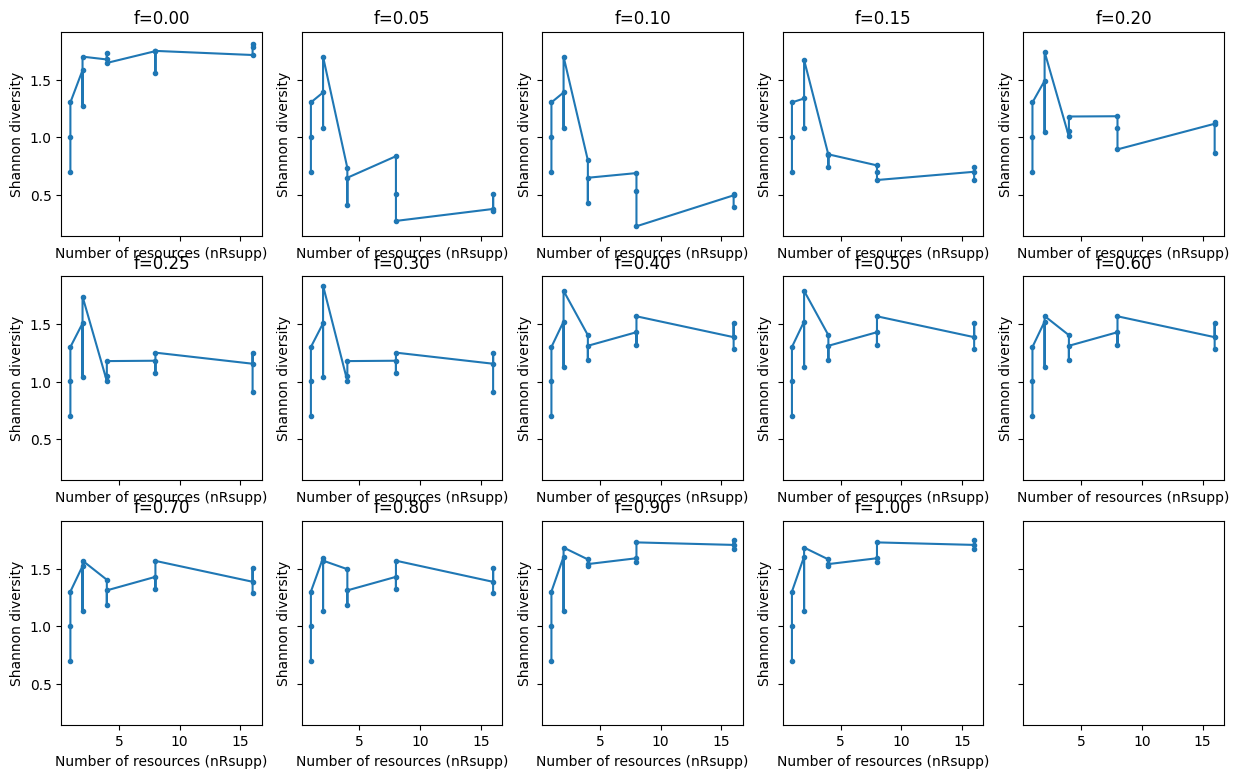

In [39]:
respath = "./simres_1219_01"
rho_gamma = 0.4
e_mean = 0.4
icomm = 0

# Model parameters
nS, nR = 20, 30
nRsupp_list = np.repeat([1, 2, 4, 8, 16], 3)
# Use only 1 and 16 for slope calc, to be compatible with Or's calculations
# USE_FOR_SLOPE_CALC = np.concatenate([np.where(nRsupp_list == 1)[0], np.where(nRsupp_list == 16)[0]])
# Use all for slope calc
USE_FOR_SLOPE_CALC = np.arange(len(nRsupp_list))

# Fractions of HACC to test
f_list = np.concatenate([np.arange(0, 0.3, 0.05), np.arange(0.3, 1.01, 0.1)])

gamma_macc, gamma_hacc = 0, 1
k_gamma = np.inf  # step function

slope_arr = np.zeros((len(comm_list), len(f_list)))  # ncomm, nfrac
slope_arr.fill(np.nan)

with open(f'{respath}/rhogamma={rho_gamma:.2f}_emean={e_mean:.1f}/Nfin_com{icomm:03d}.pkl', 'rb') as f:
    data = pickle.load(f)

if isinstance(data['final_abundance_allfracs'][0], np.ndarray):  # short output format
    nfin = np.array(data['final_abundance_allfracs'])  # (nfrac, ndiv, nspecies + nresources)
else:  # long output format
    nfin = np.array([data['final_abundance_allfracs'][ifrac][0] for ifrac in range(len(data['f_list']))])

# ---- Calculate Shannon diversity and slopes ----
shannon_div_all = np.zeros(nfin.shape[0:2])
for ifrac in range(nfin.shape[0]):
    for idiv in range(nfin.shape[1]):
        shannon_div_all[ifrac, idiv] = calc_shannon(nfin[ifrac, idiv, :data['crm_base'].nS])

for ifrac in range(nfin.shape[0]):
    k, b = np.polyfit(nRsupp_list[USE_FOR_SLOPE_CALC], shannon_div_all[ifrac, USE_FOR_SLOPE_CALC], 1)
    slope_arr[icomm, ifrac] = k
    
# Plotting shannon diversity vs nRsupp for different f
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()
for ifrac, f in enumerate(f_list):
    plt.sca(axes[ifrac])
    plt.title(f"f={f:.2f}")
    plt.plot(nRsupp_list, shannon_div_all[ifrac, :], '.-')
    plt.xlabel("Number of resources (nRsupp)")
    plt.ylabel("Shannon diversity")

## 1219_02: from binary to continuous gamma

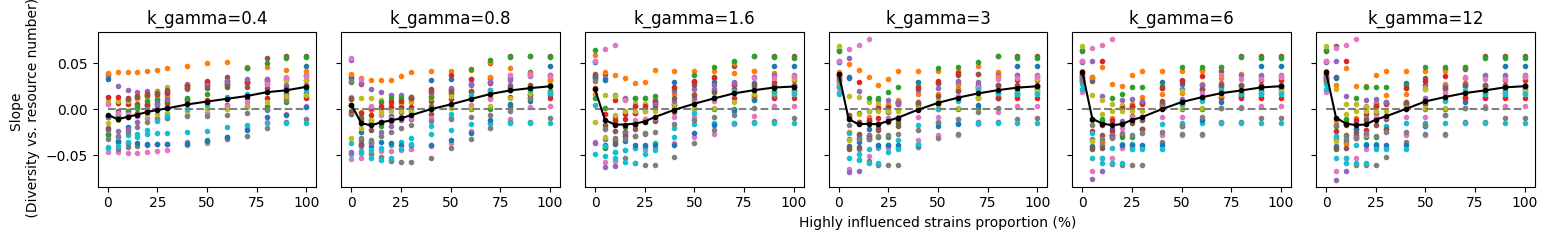

In [60]:
# Function needed to reconstruct the gamma values used in simulation
from sim_1219_02 import general_smoothstep

# save path
respath = "./simres_1219_02"

# Model parameters
nS, nR = 20, 30
nRsupp_list = np.repeat([1, 2, 4, 8, 16], 3)
# Use only 1 and 16 for slope calc, to be compatible with Or's calculations
USE_FOR_SLOPE_CALC = np.concatenate([np.where(nRsupp_list == 1)[0], np.where(nRsupp_list == 16)[0]])
# USE_FOR_SLOPE_CALC = np.arange(len(nRsupp_list))  # Use all for slope calc

# Fractions of HACC to test
f_list = np.concatenate([np.arange(0, 0.3, 0.05), np.arange(0.3, 1.01, 0.1)])
comm_list = np.arange(20)
nComm = len(comm_list)

# params
e_mean = 0.4
rho_gamma = 0.4
gamma_macc, gamma_hacc = 0, 1
k_gamma_list = [0.4, 0.8, 1.6, 3, 6, 12]

# one panel per k_gamma
fig, axes = plt.subplots(1, len(k_gamma_list), figsize=(len(k_gamma_list) * 2.6, 2.5),
                         sharex=True, sharey=True)

for ik, k_gamma in enumerate(k_gamma_list):
    plt.sca(axes[ik])
    plt.title(f"k_gamma={k_gamma}")

    slope_arr = np.zeros((len(comm_list), len(f_list)))
    slope_arr.fill(np.nan)
    
    first_comm = True
    for icomm, comm in enumerate(comm_list):
        try:
            with open(f'{respath}/kgamma={k_gamma:.1f}/Nfin_com{icomm:03d}.pkl', 'rb') as f:
                data = pickle.load(f)
        except FileNotFoundError:
            print(f"File for community {comm} not found. Skipping.")
            continue

        if isinstance(data['final_abundance_allfracs'][0], np.ndarray):
            nfin = np.array(data['final_abundance_allfracs'])  # (nfrac, ndiv, nspecies + nresources)
        else:
            nfin = np.array([data['final_abundance_allfracs'][ifrac][0] for ifrac in range(len(data['f_list']))])

        # ---- Calculate Shannon diversity and slopes ----
        shannon_div_all = np.zeros(nfin.shape[0:2])
        for ifrac in range(nfin.shape[0]):
            for idiv in range(nfin.shape[1]):
                shannon_div_all[ifrac, idiv] = calc_shannon(nfin[ifrac, idiv, :data['crm_base'].nS])

        for ifrac in range(nfin.shape[0]):
            k, b = np.polyfit(data['nRsupp_list'][USE_FOR_SLOPE_CALC], shannon_div_all[ifrac, USE_FOR_SLOPE_CALC], 1)
            slope_arr[icomm, ifrac] = k

        # ---- Fill final abundances into a DataFrame with metadata ----
        # 1. Setup constants and replicate logic
        nR_len = len(nRsupp_list)
        
        dfs = []

        # 2. Loop through the fraction dimension
        for ifrac, f in enumerate(f_list):
            # Extract the (nR_len, nS) block for this f
            abundance_block = nfin[ifrac, :, :data['crm_base'].nS]

            # Create the block of strain data
            temp_df = pd.DataFrame(abundance_block, columns=[f'strain{i + 1}' for i in range(nS)])

            # Add metadata
            temp_df['community_id'] = icomm
            temp_df['number_of_resources(nRsupp)'] = nRsupp_list
            temp_df['resource_mix_id'] = range(nR_len)
            temp_df['fraction_of_HACC(f)'] = f
            temp_df['number_of_species(nS)'] = nS
            temp_df['resource_use_efficiency(e_mean)'] = e_mean
            temp_df['HACC_correlation_with_generalist(rho_gamma)'] = rho_gamma
            temp_df['MACC_HACC_transition_steepness(k_gamma)'] = np.minimum(100, k_gamma)
            temp_df['gamma_MACC'] = gamma_macc
            temp_df['gamma_HACC'] = gamma_hacc

            # Generate gammas for this specific f (Continuous Logic from sim_1219_02)
            n_hacc = int(nS * f)
            n_macc = nS - n_hacc
            
            # Reconstruct the smoothstep gamma
            base_gamma = data['crm_base'].gamma.copy()
            if n_hacc == 0:
                x0 = base_gamma[-1] + (base_gamma[-1] - base_gamma[-2])
            elif n_macc == 0:
                x0 = base_gamma[0] - (base_gamma[1] - base_gamma[0])
            else:
                x0 = (base_gamma[n_macc - 1] + base_gamma[n_macc]) / 2
                
            gammas = general_smoothstep(base_gamma, x0=x0, k=k_gamma, y_max=gamma_hacc, y_min=gamma_macc).flatten()

            # Add gamma values
            gamma_cols = [f'gamma_strain{i + 1}' for i in range(nS)]
            temp_df[gamma_cols] = gammas

            # Add niche width
            niche_width = np.sum((data['crm_base'].v0 > 0).astype(int), axis=1) / data['crm_base'].nR
            niche_cols = [f'niche_width_strain{i + 1}' for i in range(nS)]
            temp_df[niche_cols] = niche_width

            dfs.append(temp_df)

        # 3. Combine everything into one master DataFrame
        df_data_curr = pd.concat(dfs, ignore_index=True)
        if first_comm:
            df_data = df_data_curr
            first_comm = False
        else:
            df_data = pd.concat([df_data, df_data_curr], ignore_index=True)

    # ---- Saving the DataFrame ----
    df_data.to_csv(f'{respath}/final_abundances_kgamma_{k_gamma:.1f}.csv', index=False)

    # ---- Plotting ----
    plt.plot(data['f_list'] * 100, slope_arr.T, '.')
    plt.plot(data['f_list'] * 100, np.zeros(len(data['f_list'])), '--', color='gray')
    
    # median + error bars across communities
    med = np.nanmedian(slope_arr, axis=0)
    mean = np.nanmean(slope_arr, axis=0)
    lo = np.nanpercentile(slope_arr, 25, axis=0)
    hi = np.nanpercentile(slope_arr, 75, axis=0)

    yerr = np.vstack([med - lo, hi - med])

    # plt.errorbar(f_list * 100, med, yerr=yerr, fmt='-ok', capsize=3)
    # plt.errorbar(f_list * 100, med, fmt='-ok', capsize=3)
    plt.errorbar(f_list * 100, mean, fmt='.-k', capsize=3)
    if ik == len(k_gamma_list) // 2:
        plt.xlabel("Highly influenced strains proportion (%)")
    if ik == 0:
        plt.ylabel("Slope \n (Diversity vs. resource number)")

plt.tight_layout()
plt.show()
fig.savefig(f"{respath}/crmodel_sup02_kgamma(continuous_gamma)_data.svg")

FileNotFoundError: [Errno 2] No such file or directory: './simres_1219_06/crmodel_sup02_kgamma(continuous_gamma)_formula_explain.svg'

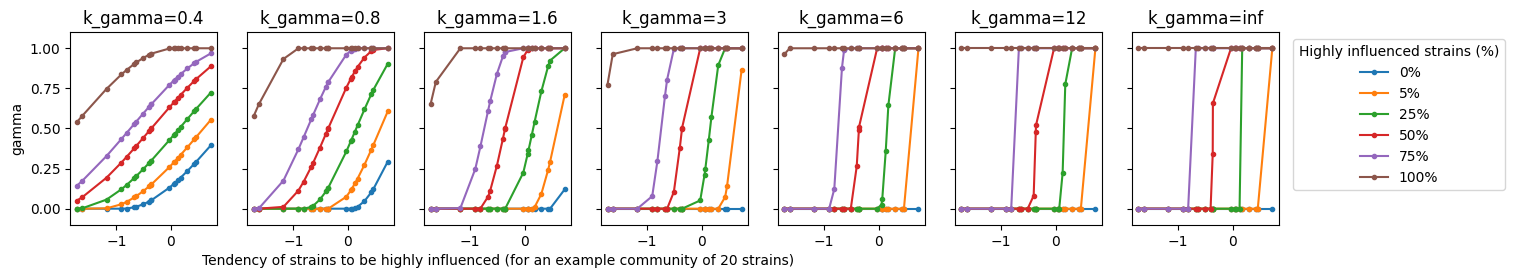

In [33]:
# a visualization of the general_smoothstep function for different k and x0
def general_smoothstep(x, x0, k, y_max, y_min=0):
    h = y_max - y_min
    if k == 0: return np.zeros_like(x) # Avoid div by zero if k is 0, though not expected here
    width = (1.5 * h) / k
    x_norm = (x - x0) / width + 0.5
    x_norm = np.clip(x_norm, 0, 1)
    return y_min + h * (3 * x_norm**2 - 2 * x_norm**3)
# gamma is correlated with nR_consumed (normalized to mean 0, std 1) with correlation rho_gamma

# plot general_smoothstep with x in [-2, 2], each panel is different k and lines show different x0
zeta = np.random.randn(20)
zeta = np.sort(zeta)
fig, axes = plt.subplots(1, 7, figsize=(2.6 * 6, 2.5), sharey=True)
k_list = [0.4, 0.8, 1.6, 3, 6, 12, 100]
for ik, k in enumerate(k_list):
    plt.sca(axes[ik])
    for f in [0, 5, 25, 50, 75, 100]:
        n_hacc = int(nS * f / 100)
        n_macc = nS - n_hacc
        if n_hacc == 0:  # step after the last species (biggest gamma)
            x0 =zeta[-1] + (zeta[-1] -zeta[-2])  # extrapolate
        elif n_macc == 0:  # step before the first species (smallest gamma)
            x0 =zeta[0] - (zeta[1] -zeta[0])  # extrapolate
        else: # step between the two species around the cutoff
            x0 = (zeta[n_macc - 1] +zeta[n_macc]) / 2
        y = general_smoothstep(zeta, x0=x0, k=k, y_max=1, y_min=0)
        plt.plot(zeta, y, '.-', label=f"{f}%")
    plt.title(f"k_gamma={k}")
    if k >= 100:
        plt.title(f"k_gamma=inf")
    if ik == 2:
        plt.xlabel('Tendency of strains to be highly influenced (for an example community of 20 strains)')
    if ik == 0:
        plt.ylabel("gamma")
    plt.ylim(-0.1, 1.1)
    if ik == len(k_list) - 1:
        plt.legend(title="Highly influenced strains (%)", bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig(f"{respath}/crmodel_sup02_kgamma(continuous_gamma)_formula_explain.svg")

## 1219_03: number of species 

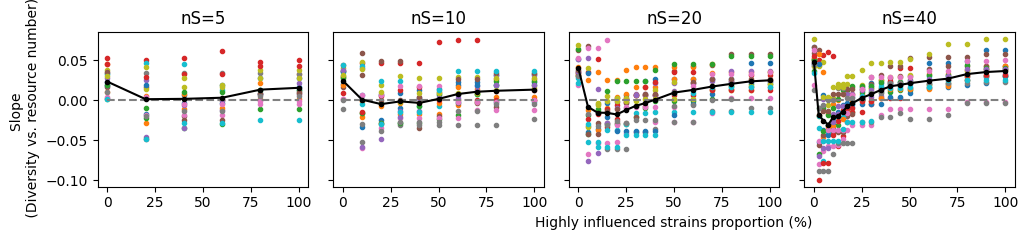

In [33]:
# save path
respath = "./simres_1219_03"

# Model parameters
nS_list = [5, 10, 20, 40]
nR = 30
nRsupp_list = np.repeat([1, 2, 4, 8, 16], 3)
# Use only 1 and 16 for slope calc, to be compatible with Or's calculations
USE_FOR_SLOPE_CALC = np.concatenate([np.where(nRsupp_list == 1)[0], np.where(nRsupp_list == 16)[0]])
# USE_FOR_SLOPE_CALC = np.arange(len(nRsupp_list))  # Use all for slope calc

# Fractions of HACC to test
comm_list = np.arange(20)
nComm = len(comm_list)

e_mean = 0.4
rho_gamma = 0.4
gamma_macc, gamma_hacc = 0, 1
k_gamma = np.inf

fig, axes = plt.subplots(1, len(nS_list), figsize=(len(nS_list) * 2.6, 2.5),
                         sharex=True, sharey=True)
for ins, nS in enumerate(nS_list):
    plt.sca(axes[ins])
    plt.title(f"nS={nS}")

    first_comm = True
    df_data = None # Initialize 
    
    # Need to initialize slope_arr dynamically based on f_list size which depends on nS
    # We will do it inside the loop after first load
    slope_arr = None

    for icomm, comm in enumerate(comm_list):
        try:
            with open(f'{respath}/nS={nS}/Nfin_com{icomm:03d}.pkl', 'rb') as f:
                data = pickle.load(f)
                current_f_list = data['f_list']
                
                if slope_arr is None:
                    slope_arr = np.zeros((len(comm_list), len(current_f_list)))
                    slope_arr.fill(np.nan)
                    
        except FileNotFoundError:
            print(f"File for community {comm} not found. Skipping.")
            continue

        if isinstance(data['final_abundance_allfracs'][0], np.ndarray):
            nfin = np.array(data['final_abundance_allfracs'])
        else:
            nfin = np.array([data['final_abundance_allfracs'][ifrac][0] for ifrac in range(len(current_f_list))])

        shannon_div_all = np.zeros(nfin.shape[0:2])
        for ifrac in range(nfin.shape[0]):
            for idiv in range(nfin.shape[1]):
                shannon_div_all[ifrac, idiv] = calc_shannon(nfin[ifrac, idiv, :data['crm_base'].nS])

        for ifrac in range(nfin.shape[0]):
            k, b = np.polyfit(data['nRsupp_list'][USE_FOR_SLOPE_CALC], shannon_div_all[ifrac, USE_FOR_SLOPE_CALC], 1)
            slope_arr[icomm, ifrac] = k

        # ---- Fill final abundances into a DataFrame with metadata ----
        # 1. Setup constants
        nR_len = len(nRsupp_list)
        dfs = []

        # 2. Loop through the fraction dimension
        for ifrac, f in enumerate(current_f_list):
            # Extract the (nR_len, nS) block for this f
            abundance_block = nfin[ifrac, :, :data['crm_base'].nS]

            # Create the block of strain data
            temp_df = pd.DataFrame(abundance_block, columns=[f'strain{i + 1}' for i in range(nS)])

            # Add metadata
            temp_df['community_id'] = icomm
            temp_df['number_of_resources(nRsupp)'] = nRsupp_list
            temp_df['resource_mix_id'] = range(nR_len)
            temp_df['fraction_of_HACC(f)'] = f
            temp_df['number_of_species(nS)'] = nS
            temp_df['resource_use_efficiency(e_mean)'] = e_mean
            temp_df['HACC_correlation_with_generalist(rho_gamma)'] = rho_gamma
            temp_df['MACC_HACC_transition_steepness(k_gamma)'] = np.minimum(100, k_gamma)
            temp_df['gamma_MACC'] = gamma_macc
            temp_df['gamma_HACC'] = gamma_hacc

            # Generate gammas for this specific f (Step function logic)
            n_hacc = int(nS * f)
            n_macc = nS - n_hacc
            gammas = np.concatenate([np.ones(n_macc) * gamma_macc,
                                     np.ones(n_hacc) * gamma_hacc])
            
            gamma_cols = [f'gamma_strain{i + 1}' for i in range(nS)]
            temp_df[gamma_cols] = gammas

            # Add niche width
            niche_width = np.sum((data['crm_base'].v0 > 0).astype(int), axis=1) / data['crm_base'].nR
            niche_cols = [f'niche_width_strain{i + 1}' for i in range(nS)]
            temp_df[niche_cols] = niche_width

            dfs.append(temp_df)

        # 3. Combine everything into one master DataFrame
        df_data_curr = pd.concat(dfs, ignore_index=True)
        if first_comm:
            df_data = df_data_curr
            first_comm = False
        else:
            df_data = pd.concat([df_data, df_data_curr], ignore_index=True)

    # ---- Saving the DataFrame ----
    df_data.to_csv(f'{respath}/final_abundances_nS_{nS}.csv', index=False)

    # ---- Plotting ----
    plt.plot(current_f_list * 100, slope_arr.T, '.')
    plt.plot(current_f_list * 100, np.zeros(len(current_f_list)), '--', color='gray')

    med = np.nanmedian(slope_arr, axis=0)
    mean = np.nanmean(slope_arr, axis=0)
    lo = np.nanpercentile(slope_arr, 25, axis=0)
    hi = np.nanpercentile(slope_arr, 75, axis=0)
    yerr = np.vstack([med - lo, hi - med])

    # plt.errorbar(current_f_list * 100, med, yerr=yerr, fmt='-ok', capsize=3)
    # plt.errorbar(current_f_list * 100, med, fmt='-ok', capsize=3)
    plt.errorbar(current_f_list * 100, mean, fmt='.-k', capsize=3)
    if ins == len(nS_list) // 2:
        plt.xlabel("Highly influenced strains proportion (%)")
    if ins == 0:
        plt.ylabel("Slope \n (Diversity vs. resource number)")

plt.tight_layout()
plt.show()
fig.savefig(f"{respath}/crmodel_sup03_nS.png", dpi=300)

## 1219_04: gamma_hacc (gamma_HIS)

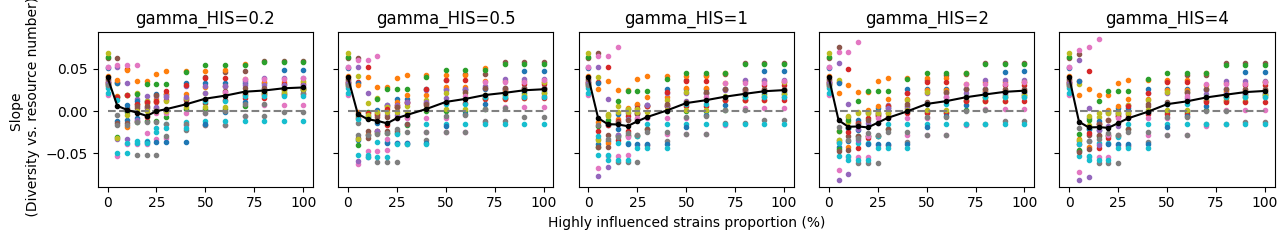

In [29]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import os

# save path
respath = "./simres_1219_04"

# Model parameters
nS, nR = 20, 30
nRsupp_list = np.repeat([1, 2, 4, 8, 16], 3)
# Use only 1 and 16 for slope calc, to be compatible with Or's calculations
USE_FOR_SLOPE_CALC = np.concatenate([np.where(nRsupp_list == 1)[0], np.where(nRsupp_list == 16)[0]])
# USE_FOR_SLOPE_CALC = np.arange(len(nRsupp_list))  # Use all for slope calc

# Fractions of HACC to test
f_list = np.concatenate([np.arange(0, 0.3, 0.05), np.arange(0.3, 1.01, 0.1)])
comm_list = np.arange(20)
nComm = len(comm_list)

e_mean = 0.4
rho_gamma = 0.4
gamma_macc = 0
gamma_hacc_list = [0.2, 0.5, 1, 2, 4]
k_gamma = np.nan # Treated as step function in sim

# one panel per gamma_hacc
fig, axes = plt.subplots(1, len(gamma_hacc_list), figsize=(len(gamma_hacc_list) * 2.6, 2.5),
                         sharex=True, sharey=True)

for igamma, gamma_hacc in enumerate(gamma_hacc_list):
    plt.sca(axes[igamma])
    plt.title(f"gamma_HIS={gamma_hacc}")

    slope_arr = np.zeros((len(comm_list), len(f_list)))
    slope_arr.fill(np.nan)
    
    first_comm = True
    for icomm, comm in enumerate(comm_list):
        try:
            with open(f'{respath}/gammahacc={gamma_hacc:.2f}/Nfin_com{icomm:03d}.pkl', 'rb') as f:
                data = pickle.load(f)
        except FileNotFoundError:
            print(f"File for community {comm} not found. Skipping.")
            continue

        if isinstance(data['final_abundance_allfracs'][0], np.ndarray):
            nfin = np.array(data['final_abundance_allfracs'])
        else:
            nfin = np.array([data['final_abundance_allfracs'][ifrac][0] for ifrac in range(len(data['f_list']))])

        shannon_div_all = np.zeros(nfin.shape[0:2])
        for ifrac in range(nfin.shape[0]):
            for idiv in range(nfin.shape[1]):
                shannon_div_all[ifrac, idiv] = calc_shannon(nfin[ifrac, idiv, :data['crm_base'].nS])

        for ifrac in range(nfin.shape[0]):
            k, b = np.polyfit(data['nRsupp_list'][USE_FOR_SLOPE_CALC], shannon_div_all[ifrac, USE_FOR_SLOPE_CALC], 1)
            slope_arr[icomm, ifrac] = k

        # ---- Fill final abundances into a DataFrame with metadata ----
        # 1. Setup constants
        nR_len = len(nRsupp_list)
        dfs = []

        # 2. Loop through the fraction dimension
        for ifrac, f in enumerate(f_list):
            abundance_block = nfin[ifrac, :, :data['crm_base'].nS]
            temp_df = pd.DataFrame(abundance_block, columns=[f'strain{i + 1}' for i in range(nS)])

            # Add metadata
            temp_df['community_id'] = icomm
            temp_df['number_of_resources(nRsupp)'] = nRsupp_list
            temp_df['resource_mix_id'] = range(nR_len)
            temp_df['fraction_of_HACC(f)'] = f
            temp_df['number_of_species(nS)'] = nS
            temp_df['resource_use_efficiency(e_mean)'] = e_mean
            temp_df['HACC_correlation_with_generalist(rho_gamma)'] = rho_gamma
            temp_df['MACC_HACC_transition_steepness(k_gamma)'] = np.minimum(100, k_gamma)
            temp_df['gamma_MACC'] = gamma_macc
            temp_df['gamma_HACC'] = gamma_hacc

            # Generate gammas (Step function)
            n_hacc = int(nS * f)
            n_macc = nS - n_hacc
            gammas = np.concatenate([np.ones(n_macc) * gamma_macc,
                                     np.ones(n_hacc) * gamma_hacc])
            
            gamma_cols = [f'gamma_strain{i + 1}' for i in range(nS)]
            temp_df[gamma_cols] = gammas

            # Add niche width
            niche_width = np.sum((data['crm_base'].v0 > 0).astype(int), axis=1) / data['crm_base'].nR
            niche_cols = [f'niche_width_strain{i + 1}' for i in range(nS)]
            temp_df[niche_cols] = niche_width

            dfs.append(temp_df)

        # 3. Combine everything into one master DataFrame
        df_data_curr = pd.concat(dfs, ignore_index=True)
        if first_comm:
            df_data = df_data_curr
            first_comm = False
        else:
            df_data = pd.concat([df_data, df_data_curr], ignore_index=True)

    # ---- Saving the DataFrame ----
    df_data.to_csv(f'{respath}/final_abundances_gammahacc_{gamma_hacc:.2f}.csv', index=False)

    # ---- Plotting ----
    plt.plot(data['f_list'] * 100, slope_arr.T, '.')
    plt.plot(data['f_list'] * 100, np.zeros(len(data['f_list'])), '--', color='gray')

    med = np.nanmedian(slope_arr, axis=0)
    mean = np.nanmean(slope_arr, axis=0)
    lo = np.nanpercentile(slope_arr, 25, axis=0)
    hi = np.nanpercentile(slope_arr, 75, axis=0)

    yerr = np.vstack([med - lo, hi - med])

    # plt.errorbar(f_list * 100, med, yerr=yerr, fmt='-ok', capsize=3)
    # plt.errorbar(f_list * 100, med, fmt='-ok', capsize=3)
    plt.errorbar(f_list * 100, mean, fmt='.-k', capsize=3)
    if igamma == len(gamma_hacc_list) // 2:
        plt.xlabel("Highly influenced strains proportion (%)")
    if igamma == 0:
        plt.ylabel("Slope \n (Diversity vs. resource number)")

plt.tight_layout()
plt.show()
fig.savefig(f"{respath}/crmodel_sup04_gammahacc.png", dpi=300)

## 1219_05: gamma impact efficient e instead of affinity km

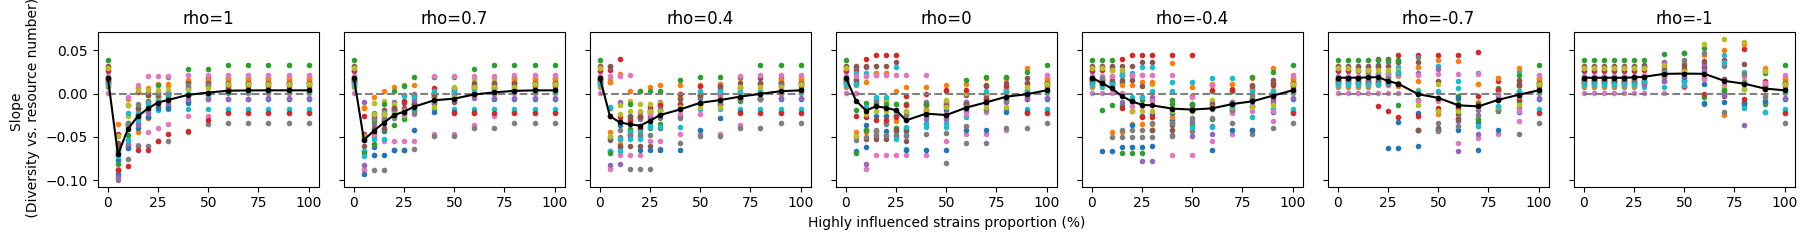

In [31]:
respath = "./simres_1219_05"

# Model parameters
nS, nR = 20, 30
nRsupp_list = np.repeat([1, 2, 4, 8, 16], 3)
# Use only 1 and 16 for slope calc, to be compatible with Or's calculations
USE_FOR_SLOPE_CALC = np.concatenate([np.where(nRsupp_list == 1)[0], np.where(nRsupp_list == 16)[0]])
# USE_FOR_SLOPE_CALC = np.arange(len(nRsupp_list))  # Use all for slope calc

# Fractions of HACC to test
f_list = np.concatenate([np.arange(0, 0.3, 0.05), np.arange(0.3, 1.01, 0.1)])
comm_list = np.arange(20)
nComm = len(comm_list)

e_mean = 0.2
rho_gamma_list = [1, 0.7, 0.4, 0, -0.4, -0.7, -1]
gamma_macc = 0
gamma_hacc_list = [1] # [0.2, 0.5, 1, 2, 4, 8] doesn't have much effect, so just use 1 for simplicity
k_gamma = np.inf  # step function

fig, axes = plt.subplots(len(gamma_hacc_list), len(rho_gamma_list), figsize=(len(rho_gamma_list) * 2.6, len(gamma_hacc_list) * 2.5),
                         sharex=True, sharey=True)
axes = np.array(axes).reshape((len(gamma_hacc_list), len(rho_gamma_list)))

for irho, rho_gamma in enumerate(rho_gamma_list):
    for igamma, gamma_hacc in enumerate(gamma_hacc_list):
        plt.sca(axes[igamma, irho])
        plt.title(f"rho={rho_gamma}")

        slope_arr = np.zeros((len(comm_list), len(f_list)))
        slope_arr.fill(np.nan)

        first_comm = True
        for icomm, comm in enumerate(comm_list):
            try:
                with open(f'{respath}/rhogamma={rho_gamma:.2f}_gammahacc={gamma_hacc:.2f}/Nfin_com{icomm:03d}.pkl',
                          'rb') as f:
                    data = pickle.load(f)
            except FileNotFoundError:
                print(f"File for community {comm} not found. Skipping.")
                continue

            if isinstance(data['final_abundance_allfracs'][0], np.ndarray):
                nfin = np.array(data['final_abundance_allfracs'])
            else:
                nfin = np.array([data['final_abundance_allfracs'][ifrac][0] for ifrac in range(len(data['f_list']))])

            shannon_div_all = np.zeros(nfin.shape[0:2])
            for ifrac in range(nfin.shape[0]):
                for idiv in range(nfin.shape[1]):
                    shannon_div_all[ifrac, idiv] = calc_shannon(nfin[ifrac, idiv, :data['crm_base'].nS])

            for ifrac in range(nfin.shape[0]):
                k, b = np.polyfit(data['nRsupp_list'][USE_FOR_SLOPE_CALC], shannon_div_all[ifrac, USE_FOR_SLOPE_CALC], 1)
                slope_arr[icomm, ifrac] = k

            # ---- Fill final abundances into a DataFrame with metadata ----
            # 1. Setup constants
            nR_len = len(nRsupp_list)
            dfs = []

            # 2. Loop through the fraction dimension
            for ifrac, f in enumerate(f_list):
                abundance_block = nfin[ifrac, :, :data['crm_base'].nS]
                temp_df = pd.DataFrame(abundance_block, columns=[f'strain{i + 1}' for i in range(nS)])

                # Add metadata
                temp_df['community_id'] = icomm
                temp_df['number_of_resources(nRsupp)'] = nRsupp_list
                temp_df['resource_mix_id'] = range(nR_len)
                temp_df['fraction_of_HACC(f)'] = f
                temp_df['number_of_species(nS)'] = nS
                temp_df['resource_use_efficiency(e_mean)'] = e_mean
                temp_df['HACC_correlation_with_generalist(rho_gamma)'] = rho_gamma
                temp_df['MACC_HACC_transition_steepness(k_gamma)'] = np.minimum(100, k_gamma)
                temp_df['gamma_MACC'] = gamma_macc
                temp_df['gamma_HACC'] = gamma_hacc

                # Generate gammas (Step function)
                n_hacc = int(nS * f)
                n_macc = nS - n_hacc
                gammas = np.concatenate([np.ones(n_macc) * gamma_macc,
                                         np.ones(n_hacc) * gamma_hacc])
                
                gamma_cols = [f'gamma_strain{i + 1}' for i in range(nS)]
                temp_df[gamma_cols] = gammas

                # Add niche width
                niche_width = np.sum((data['crm_base'].v0 > 0).astype(int), axis=1) / data['crm_base'].nR
                niche_cols = [f'niche_width_strain{i + 1}' for i in range(nS)]
                temp_df[niche_cols] = niche_width

                dfs.append(temp_df)

            # 3. Combine everything into one master DataFrame
            df_data_curr = pd.concat(dfs, ignore_index=True)
            if first_comm:
                df_data = df_data_curr
                first_comm = False
            else:
                df_data = pd.concat([df_data, df_data_curr], ignore_index=True)

        # ---- Saving the DataFrame ----
        df_data.to_csv(f'{respath}/final_abundances_rhogamma_{rho_gamma:.2f}_gammahacc_{gamma_hacc:.2f}.csv', index=False)

        # ---- Plotting ----
        plt.plot(data['f_list'] * 100, slope_arr.T, '.')
        plt.plot(data['f_list'] * 100, np.zeros(len(data['f_list'])), '--', color='gray')

        med = np.nanmedian(slope_arr, axis=0)
        mean = np.nanmean(slope_arr, axis=0)
        lo = np.nanpercentile(slope_arr, 25, axis=0)
        hi = np.nanpercentile(slope_arr, 75, axis=0)

        yerr = np.vstack([med - lo, hi - med])

        # plt.errorbar(f_list * 100, med, yerr=yerr, fmt='-ok', capsize=3)
        # plt.errorbar(f_list * 100, med, fmt='-ok', capsize=3)
        plt.errorbar(f_list * 100, mean, fmt='.-k', capsize=3)
        if irho == len(rho_gamma_list) // 2 and igamma == len(gamma_hacc_list) - 1:
            plt.xlabel("Highly influenced strains proportion (%)")
        if igamma == 0 and irho == 0:
            plt.ylabel("Slope \n (Diversity vs. resource number)")

plt.tight_layout()
plt.show()
fig.savefig(f"{respath}/crmodel_sup05_gamma_impact_e.svg")
fig.savefig(f"{respath}/crmodel_sup05_gamma_impact_e.png", dpi=300)